In [42]:
import pickle
import time
import matplotlib.pyplot as plt
import tqdm
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
import os
from yolov3_tf2.utils import freeze_all
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)
import yolov3_tf2.dataset_chars as dataset
import tensorflow.keras as keras
from tensorflow.keras.layers import Flatten, Dense, Dropout, Reshape
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt

In [ ]:
DATA_SIZE=13163
VAL_SIZE=int(DATA_SIZE*0.15)

flags.DEFINE_integer('size', 32, 'size of each character should be resize to')
flags.DEFINE_integer('epochs', 50, 'epoch num')
flags.DEFINE_integer('batch_size', 32, 'size of each batch')
flags.DEFINE_string('dataset_path', './data/chars_data.tfrecord', 'path to output dataset file')
flags.DEFINE_string('classes_path', './data/chars_data.names', 'path to output class file')

app._run_init(['resnet'], app.parse_flags_with_usage)

In [60]:
all_dataset = dataset.load_tfrecord_dataset(FLAGS.dataset_path, size=FLAGS.size)
all_dataset = all_dataset.map(lambda x, y: (dataset.transform_images(x, FLAGS.size), y))
all_dataset = all_dataset.shuffle(buffer_size=1024)
val_dataset, train_dataset = all_dataset.take(VAL_SIZE), all_dataset.skip(VAL_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).batch(FLAGS.batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).batch(FLAGS.batch_size)

class_map = {name: idx for idx, name in enumerate(open(FLAGS.classes_path).read().splitlines())}
class_num = len(class_map)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 34)                17442     
Total params: 24,916,898
Trainable params: 1,329,186
Non-trainable params: 23,587,712
__________________________________

In [ ]:
restnet = tf.keras.applications.ResNet50(classes=class_num, include_top=False, weights='imagenet',
                                       input_shape=(FLAGS.size, FLAGS.size, 3))

output = Flatten()(restnet.layers[-1].output)
restnet = Model(inputs=restnet.input, outputs=output)
for layer in restnet.layers:
    layer.trainable = False

model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(class_num, activation='sigmoid'))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint('chars_checkpoints/resnet50_train_{epoch}.tf', verbose=1,
                    save_best_only=True, save_weights_only=True, mode='min'),
    TensorBoard(log_dir='logs/chars/resnet50')
]

In [61]:
history = model.fit(train_dataset,
                    epochs=FLAGS.epochs,
                    callbacks=callbacks,
                    validation_data=val_dataset)

Epoch 1/50
    350/Unknown - 7s 20ms/step - loss: 1.5007 - accuracy: 0.5430
Epoch 00001: val_loss improved from inf to 9.03939, saving model to chars_checkpoints/resnet50_train_1.tf
350/350 [==============================] - 10s 28ms/step - loss: 1.5007 - accuracy: 0.5430 - val_loss: 9.0394 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50
349/350 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.7927
Epoch 00002: val_loss improved from 9.03939 to 5.25530, saving model to chars_checkpoints/resnet50_train_2.tf
350/350 [==============================] - 8s 23ms/step - loss: 0.6880 - accuracy: 0.7931 - val_loss: 5.2553 - val_accuracy: 0.0334 - lr: 0.0010
Epoch 3/50
350/350 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.8494
Epoch 00003: val_loss improved from 5.25530 to 3.31825, saving model to chars_checkpoints/resnet50_train_3.tf
350/350 [==============================] - 8s 23ms/step - loss: 0.4769 - accuracy: 0.8494 - val_loss: 3.3182 - 

In [27]:
all_dataset = dataset.load_tfrecord_dataset(FLAGS.dataset_path, size=FLAGS.size)
all_dataset = all_dataset.map(lambda x, y: (tf.expand_dims(dataset.transform_images(x, FLAGS.size), axis=0), y))

In [28]:
ds = tf.data.TFRecordDataset('./data/chars_data.tfrecord')

In [54]:
img, label = next(iter(train_dataset.take(1)))

W0507 15:06:41.575154 140152253048640 image.py:708] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


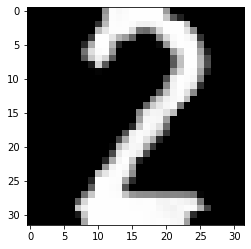

In [55]:
print(label.numpy())
plt.imshow(img[0].numpy())
